In [2]:
# 📦 Vereiste imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing, feature selection, and decomposition
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFECV, SequentialFeatureSelector, f_classif

# Scikit-learn models and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Additional imports
import pickle


# load data + feature_mask

data = pd.read_excel(r"..\..\TrainData.xlsx")

with open(r"..\..\mask_selected_features.pkl", "rb") as f:
    feature_mask = pickle.load(f)


# Data preprocessing

data = data.drop_duplicates()

# 🎯 Stap 3 – Split in features en labels
X = data.drop(columns="label")
y = data["label"]

# 🔁 Zet y om naar numeriek met behoud van pandas Series
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)

# ❓ Hoeveel missende waarden blijven over?
print("Totaal aantal missende waarden:", X.isnull().sum().sum())

# ⚠️ Stap 4 – NaNs imputer (mediaan)
X = X.fillna(X.median(numeric_only=True))


#Data selectie + normalisatie

X_Scaled = StandardScaler().fit_transform(X)
X_selected = X_Scaled[:, feature_mask]



Totaal aantal missende waarden: 0


In [45]:
#baseline test
KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
score = cross_val_score(KNN, X_selected, y, cv=StratifiedKFold(5), scoring="roc_auc")
print(score)
print(np.mean(score))

[0.83673469 0.64285714 0.89285714 0.91326531 0.83791209]
0.8247252747252748


In [ ]:
#Obtain nested score for KNN with PCA


NUM_TRIALS = 100
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    outer_cv = StratifiedKFold(n_splits=4+1, shuffle=True, random_state=i)
    inner_cv = StratifiedKFold(n_splits=4+1, shuffle=True, random_state=i)

    pipeline = Pipeline([
    ("pca", PCA()),
    ("knn", KNeighborsClassifier(n_jobs=-1)),
    ])

    param_grid = {
        "pca__n_components": [0.95, 0.99, 0.999],
        "knn__n_neighbors": [7, 8, 9,10,11 12,12, 14, 15,16, 18, 20, 22, 24, 26, 28, 30]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
    nested_score = cross_val_score(clf, X=X_selected, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()


print(
    "Average of {:6f} with std. dev. of {:6f}.".format(
        nested_scores.mean(), nested_scores.std()
    )
)

Average of 0.813884 with std. dev. of 0.019804.


In [ ]:
# difficult nested score to see best params. Perform grid-search with nested cross-validation for hyperparameter tuning

NUM_TRIALS = 100
nested_scores = np.zeros(NUM_TRIALS)



pipeline = Pipeline([
   ("pca", PCA()),
    ("knn", KNeighborsClassifier(n_jobs=-1)),
])

param_grid = {
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    "knn__n_neighbors": [7 , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
}

nested_scores = np.zeros(NUM_TRIALS)
all_best_params = []

for i in range(NUM_TRIALS):
    # Create outer and inner cross-validation objects
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    # Store the best parameters and scores for each outer fold
    best_params = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X_selected, y):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create a new GridSearchCV for each inner fold
        clf = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
        
        # Fit GridSearchCV on the training data
        clf.fit(X_train, y_train)
        
        # Get the best model from inner CV
        best_model = clf.best_estimator_
        
        # Evaluate the best model on the outer test fold
        y_pred = best_model.predict_proba(X_test)[:, 1]
        outer_score = roc_auc_score(y_test, y_pred)
        
        # Append the best parameters and outer score
        best_params.append(clf.best_params_)
        outer_scores.append(outer_score)
    
    # Store the mean score for this trial
    nested_scores[i] = np.mean(outer_scores)
    all_best_params.append([i, best_params])

df = pd.DataFrame(test, columns=["inner_1", "inner_2", "inner_3", "inner_4", "inner_5"])

with open(r"output_grid_searches\KNN_nested_scores.pkl", "wb") as f:
    pickle.dump(nested_scores, f)

with open(r"output_grid_searches\KNN_best_params.pkl", "wb") as f:
    pickle.dump(df, f)

# Print results
print(f"Average performance across {NUM_TRIALS} trials: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")


Average performance across 100 trials: 0.8057 ± 0.0234


In [4]:
with open(r"output_grid_searches\KNN_best_params.pkl", "rb") as f:
    best_param = pickle.load(f)

with open(r"output_grid_searches\KNN_nested_scores.pkl", "rb") as f:
    nested_scores = pickle.load(f)



In [8]:
# Calculate the confidence interval for the nested scores

confidence = 0.95  # 95% confidence level
mean_score = np.mean(nested_scores)
std_error = np.std(nested_scores, ddof=1) / np.sqrt(len(nested_scores))  # Standard error of the mean
confidence_interval_lower = mean_score - (std_error * 1.96)  # Z-score for 95% confidence interval
confidence_interval_upper = mean_score + (std_error * 1.96)  # Z-score for 95% confidence interval

print(f"gemiddeld = {mean_score} 95% Confidence Interval: {confidence_interval_lower:.4f} to {confidence_interval_upper:.4f}")

gemiddeld = 0.8056813186813188 95% Confidence Interval: 0.8011 to 0.8103


In [41]:
best_params = pd.Series(best_param.values.ravel())

best_params.value_counts()[0:10].to_excel(r"test1.xlsx")

In [37]:
test.value_counts()[0:10]

{'knn__n_neighbors': 7, 'pca__n_components': 13}    18
{'knn__n_neighbors': 7, 'pca__n_components': 17}    13
{'knn__n_neighbors': 7, 'pca__n_components': 12}    13
{'knn__n_neighbors': 7, 'pca__n_components': 8}     13
{'knn__n_neighbors': 7, 'pca__n_components': 11}    11
{'knn__n_neighbors': 8, 'pca__n_components': 17}    11
{'knn__n_neighbors': 8, 'pca__n_components': 14}    11
{'knn__n_neighbors': 9, 'pca__n_components': 14}    11
{'knn__n_neighbors': 7, 'pca__n_components': 10}    11
{'knn__n_neighbors': 7, 'pca__n_components': 14}    10
Name: count, dtype: int64

In [43]:
# train and save final model

# Save the final trained KNN model along with feature masks and scaler

# Step 1: Standardize and select features
scaler_standard = StandardScaler()
scaler_standard.fit(X)
X_Scaled = scaler_standard.transform(X)
X_selected = X_Scaled[:, feature_mask]

#step 2: run the PCA
pca_transformer = PCA(n_components=13) 
pca_transformer.fit(X_selected)
X_PCA = pca_transformer.transform(X_selected)


# Step 3: Initialize the custom KNN classifier
KNN = KNeighborsClassifier(n_neighbors=7)


# Step 4: Train the final KNN model on the selected features
KNN.fit(X_PCA, y)

# Step 7: Save the trained KNN model, PCA transformer and scaler to disk
with open(r'KNNFinal\KNN_model.pkl', 'wb') as file:
    pickle.dump(KNN, file)  # Save the trained KNN model

with open(r'KNNFinal\pca_transformer.pkl', 'wb') as file:
    pickle.dump(pca_transformer, file)  # Save PCA transformer

with open(r'KNNFinal\KNN_Scaler.pkl', 'wb') as file:
    pickle.dump(scaler_standard, file)  # Save the scaler used for standardization


0      0
1      0
2      0
3      0
4      0
      ..
134    1
135    1
136    0
137    0
138    0
Length: 139, dtype: int64

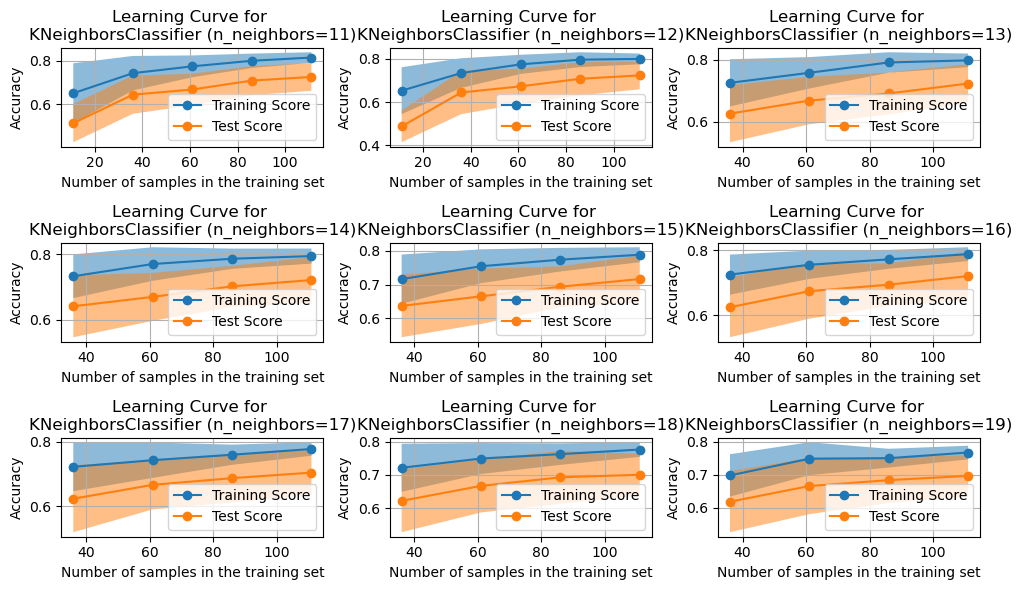

In [5]:
# show a learning curve

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))




common_params = {
    "X": X_selected,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4+1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for index, i in enumerate([10, 11, 12, 13, 14, 15, 16, 17, 18]):
    row, col = divmod(index, 3)
    KNN = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)

    LearningCurveDisplay.from_estimator(KNN, **common_params, ax=ax[row, col])
    handles, label = ax[row,col].get_legend_handles_labels()
    ax[row, col].legend(handles[:2], ["Training Score", "Test Score"])
    ax[row, col].grid(True)
    ax[row, col].set_title(f"Learning Curve for \n{KNN.__class__.__name__} (n_neighbors={i+1})")

plt.tight_layout()
plt.show()

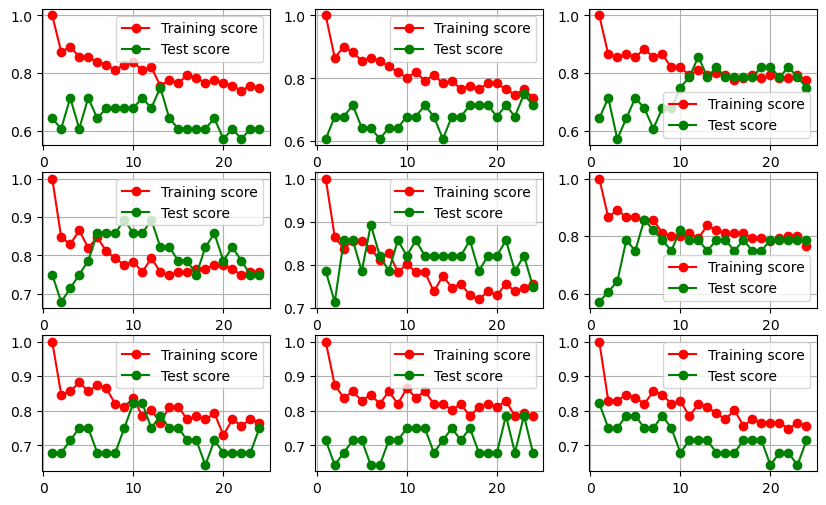

In [5]:
# nog een keer learning curve maar dan met knn (vraagteken, vraagteken)

from sklearn import neighbors

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))
for i in range(9):
    row, col = divmod(i, 3)
    train_scores = []
    test_scores = []
    k_list = list(range(1, 25, 1))

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, stratify=y)

    for k in k_list:
        clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(X_train, y_train)

        # Test the classifier on the training data and plot
        score_train = clf_knn.score(X_train, y_train)
        score_test = clf_knn.score(X_test, y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)

    ax[row,col].grid()
    ax[row,col].plot(k_list, train_scores, 'o-', color="r",
            label="Training score")
    ax[row,col].plot(k_list, test_scores, 'o-', color="g",
            label="Test score")

    ax[row,col].legend()

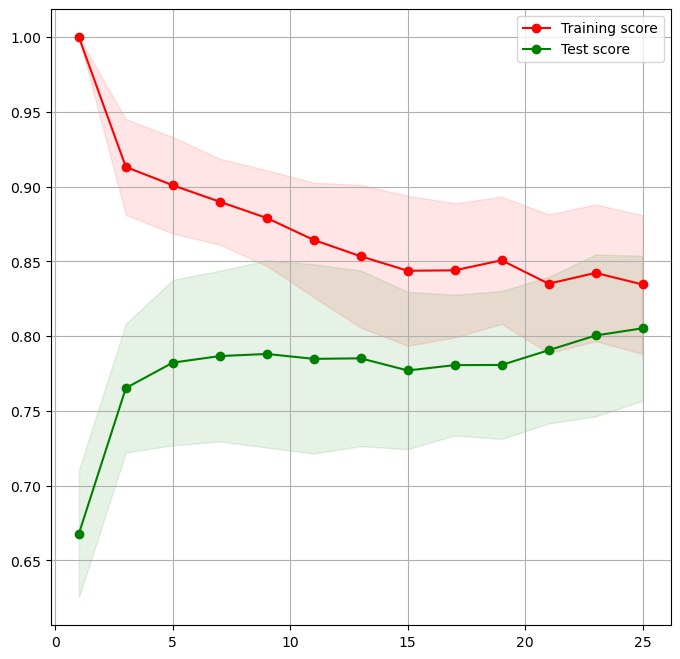

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit


k_list = list(range(1, 26, 2))
all_train = []
all_test = []

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(X_selected, y):
    train_scores = []
    test_scores = []

    split_X_train = X_selected[train_index]
    split_y_train = y[train_index]
    split_X_test = X_selected[test_index]
    split_y_test = y[test_index]

    for k in k_list:
        clf_knn = KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        train_proba = clf_knn.predict_proba(split_X_train)[:, 1]
        test_proba = clf_knn.predict_proba(split_X_test)[:, 1]

        score_train = roc_auc_score(split_y_train, train_proba)
        score_test = roc_auc_score(split_y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    all_train.append(train_scores)
    all_test.append(test_scores)


# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")
ax.legend()

Best classifier: k=7
Best classifier: k=11
Best classifier: k=7
Best classifier: k=5
Best classifier: k=5
Best classifier: k=5
Best classifier: k=7
Best classifier: k=7
Best classifier: k=5
Best classifier: k=3
The optimal N=6


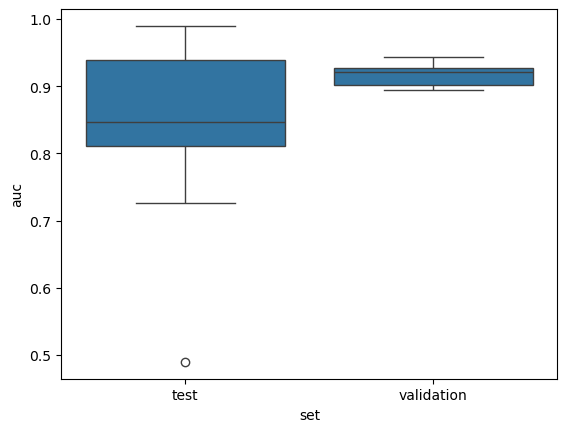

In [11]:
import seaborn as sns

# Create a 20 fold stratified CV iterator
cv_20fold = StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_selected, y):
    # Split the data properly
    X_validation = X_selected[validation_index]
    y_validation = y[validation_index]

    X_test = X_selected[test_index]
    y_test = y[test_index]

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)

    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]

    # Get the auc
    auc = roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })

    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]

    # Get the auc
    auc_validation = roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })

# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")